In [1]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt

In [2]:
param_drift = np.r_[np.linspace(0,0,1000), np.linspace(0,3,1000), np.linspace(3,3,1000)]
param_step = np.r_[np.linspace(0,0,1000), np.linspace(3,3,1000)]

In [3]:
rng = np.random.default_rng(12121)

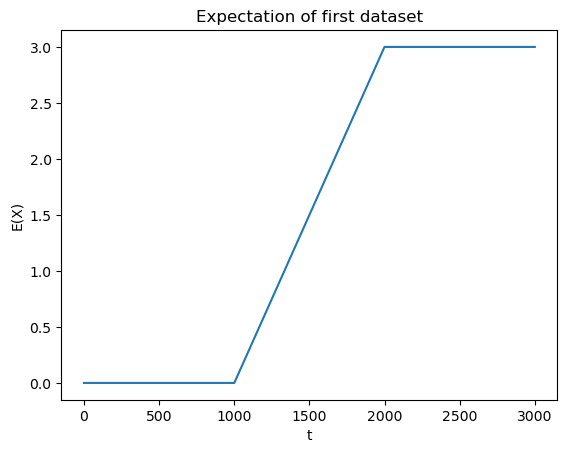

In [4]:
plt.plot(param_drift)
plt.title('Expectation of first dataset')
plt.ylabel('E(X)')
plt.xlabel('t')
plt.savefig('exp_first.eps', format='eps')

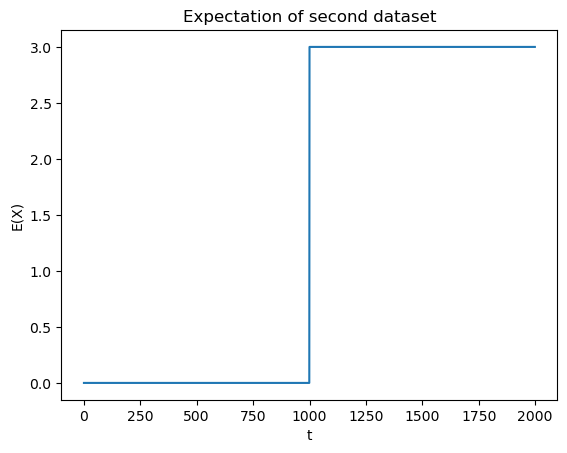

In [5]:
plt.plot(param_step)
plt.title('Expectation of second dataset')
plt.ylabel('E(X)')
plt.xlabel('t')
plt.savefig('exp_second.eps', format='eps')

In [6]:
def split(data):
    train = data[0::2]
    calib = data[1::2]
    return train,calib

In [7]:
drift_rand = np.empty(len(param_drift))
for i in range(len(drift_rand)):
    drift_rand[i] = rng.normal(loc=param_drift[i],size=1)

/tmp/ipykernel_152548/2902703023.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  drift_rand[i] = rng.normal(loc=param_drift[i],size=1)


In [8]:
step_rand = np.empty(len(param_step))
for i in range(len(step_rand)):
    step_rand[i] = rng.normal(loc=param_step[i],size=1)

/tmp/ipykernel_152548/3950158063.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  step_rand[i] = rng.normal(loc=param_step[i],size=1)


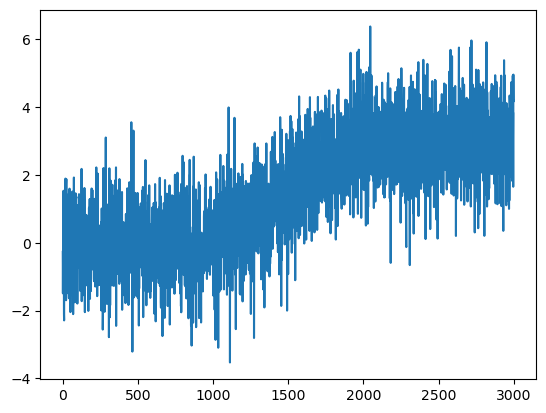

In [9]:
plt.plot(drift_rand)

In [10]:
def nonconfscores(data):
    train,calib = split(data)
    model = np.mean(train)
    scores = calib - model
    return model, scores

In [11]:
def p_value_nonex(model, scores, weights, test_point):
    alpha_n = test_point - model 
    ind = np.argsort(scores)
    alpha_above = np.argwhere(scores[ind]>alpha_n)
    alpha_below = np.argwhere(scores[ind]<alpha_n)
    tau = rng.uniform()
    if alpha_below.size == 0:
        p_value = weights[ind][0]*tau
    elif alpha_above.size ==0:
        p_value = np.sum(weights) + tau*(1 - np.sum(weights))
    else:
        p_value = np.sum(weights[ind][:alpha_above[0][0]]) + tau*weights[ind][alpha_above[0]] 
    
    return p_value

In [12]:
def p_value(model, scores, test_point):
    scores = np.sort(scores)
    alpha_n = test_point - model
    alpha_eq = np.argwhere(scores==alpha_n)
    alpha_below = np.argwhere(scores<alpha_n)
    tau = rng.uniform()
    p_value = len(alpha_below)*(1/(len(scores)+1)) + tau*len(alpha_eq)*(1/(len(scores)+1)) + tau/(len(scores)+1)
    return p_value


In [13]:
def predict_distr(model, scores, weights):
    ind = np.argsort(scores)
    distr_init = model + scores[ind]
    distr_nonex = np.interp(np.linspace(0.001, 0.999,200),np.cumsum(weights[ind]), distr_init)
    distr = np.interp(np.linspace(0.001, 0.999,200), np.linspace(0.001, 0.999,len(distr_init)), distr_init)
    return distr_nonex, distr


In [14]:
def predict_distr2(model, scores, weights):
    ind = np.argsort(scores)
    distr_init = model + scores[ind]
    distr_nonex = np.interp(np.linspace(0.001, 0.999,200),np.cumsum(weights[ind]), distr_init)
    distr = np.interp(np.linspace(0.001, 0.999,200), np.linspace(1/(len(distr_init)+1), 1-1/(len(distr_init)+1),len(distr_init)), distr_init)
    return distr_nonex, distr

In [15]:
def crps(predictions, label):
    scores = np.empty(len(label))
    length = predictions.shape[1]
    
    for i in range(len(label)):
        low = predictions[i,:][predictions[i,:]<=label[i]]
        up = predictions[i,:][predictions[i,:]>=label[i]]
        f_low = np.cumsum((1/length)*np.ones(len(low)))
        if f_low.size > 0:
            f_up = np.cumsum((1/length)*np.ones(len(up))) + f_low[-1]
        else:
            f_up = np.cumsum((1/length)*np.ones(len(up)))
        low_score = np.sum((np.power(f_low[:-1],2)+np.power(f_low[1:],2))*(low[1:]-low[:-1]))/2
        up_score = np.sum((np.power((f_up[:-1]-1),2)+np.power((f_up[1:]-1),2))*(up[1:]-up[:-1]))/2
        scores[i] = low_score + up_score

    return np.mean(scores), scores

In [16]:
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad

In [17]:
def get_density_estimate(p_values):
    P = np.array([[-p, p, 2-p] for p in p_values]).flatten()[:, np.newaxis]
    if len(P) == 0:
        return None
    kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(P)
    return kde

In [18]:
def f(p, d):
    if not d: 
        return 1
    if 0 <= p <= 1:
        func = lambda p :np.exp(d.score_samples([[p]])[0])
        norm_fac = quad(func, 0, 1)
        return np.exp(d.score_samples([[p]])[0]) / norm_fac[0]
    else:
        return 0.0

In [19]:
def plugin_martingale(p_values):
    log_plugin_martingale = [0]
    for i, p_i in enumerate(p_values):
        d = get_density_estimate(p_values[:i])
        log_plugin_martingale.append(log_plugin_martingale[i] + np.log(f(p_i, d)))
    log_plugin_martingale = log_plugin_martingale[1:]
    plugin_martingale = [np.exp(m) for m in log_plugin_martingale]
    return plugin_martingale

In [20]:
def movingaverage(data, window_length):
    ma = np.empty((len(data)-window_length))
    for i in np.arange(len(data)-window_length):
        ma[i] = np.mean(data[i:i+window_length])
    return ma

In [21]:
p_values = np.array([])
p_values_nonex = np.array([])
distr_nx = np.array([])
distr_std = np.array([])
label_distr = np.array([])

for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    weights = np.power(0.999,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr2(model,scores,weights)
    p_val = p_value(model,scores,drift_rand[i+1])
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx = np.array([distr_nonex])
        distr_std = np.array([distr])
        label_distr = np.reshape(sc.stats.norm.ppf(np.linspace(0.001, 0.999,200),param_drift[i+1]),(-1,1))
    else:
        distr_nx = np.concatenate((distr_nx,np.array([distr_nonex])),axis=0)
        distr_std = np.concatenate((distr_std,np.array([distr])),axis=0)
        label_distr = np.concatenate((label_distr,np.reshape(sc.stats.norm.ppf(np.linspace(0.001, 0.999,200),param_drift[i+1]),(-1,1))),axis=1)
    
    p_values = np.r_[p_values, p_val]
    p_values_nonex = np.r_[p_values_nonex, p_nonex]


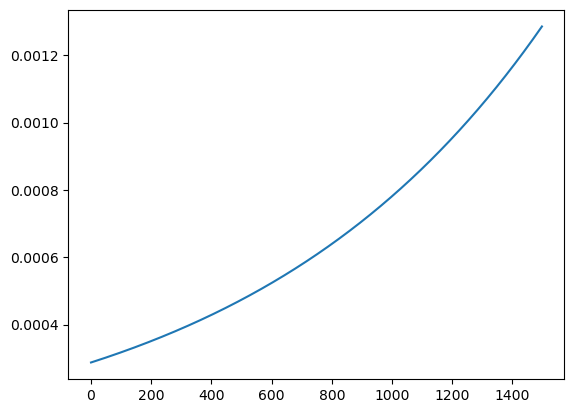

In [22]:
plt.plot(weights)

In [23]:
p_values_nonex1 = np.array([])
distr_nx1 = np.array([])

for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    weights = np.power(0.995,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx1 = np.array([distr_nonex])
    else:
        distr_nx1 = np.concatenate((distr_nx1,np.array([distr_nonex])),axis=0)
    p_values_nonex1 = np.r_[p_values_nonex1, p_nonex]

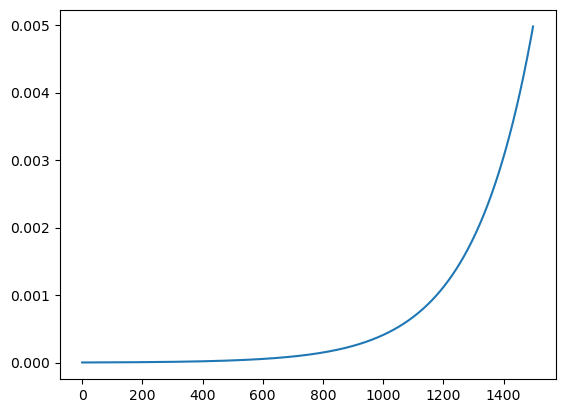

In [24]:
plt.plot(weights)

In [25]:
p_values_nonex2 = np.array([])
distr_nx2 = np.array([])

for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    weights = np.power(0.99,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx2 = np.array([distr_nonex])
    else:
        distr_nx2 = np.concatenate((distr_nx2,np.array([distr_nonex])),axis=0)
    p_values_nonex2 = np.r_[p_values_nonex2, p_nonex]

In [26]:
p_values_nonex3 = np.array([])
distr_nx3 = np.array([])

for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    weights = np.power(0.98,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx3 = np.array([distr_nonex])
    else:
        distr_nx3 = np.concatenate((distr_nx3,np.array([distr_nonex])),axis=0)
    p_values_nonex3 = np.r_[p_values_nonex3, p_nonex]

Power_divergenceResult(statistic=2369.5194077631054, pvalue=0.0)


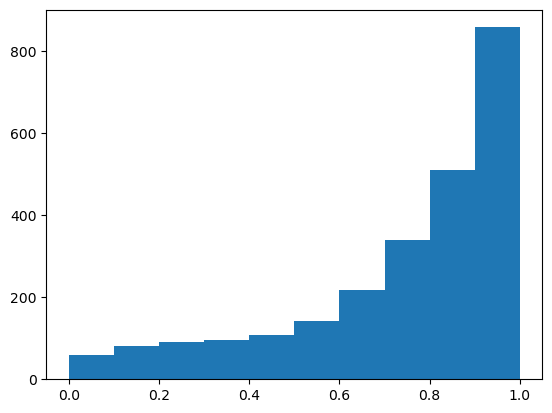

In [27]:
n = plt.hist(p_values)
print(sc.stats.chisquare(n[0]))

Power_divergenceResult(statistic=1514.6334533813526, pvalue=0.0)


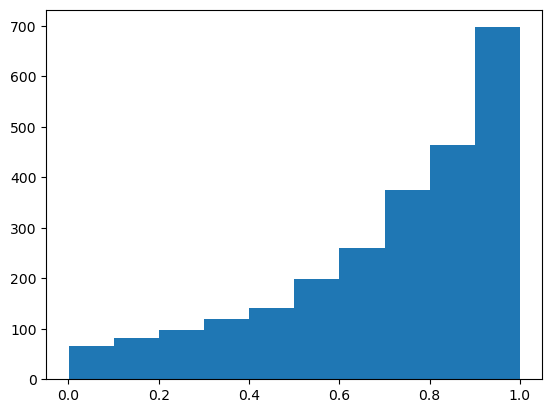

In [28]:
n = plt.hist(p_values_nonex)
print(sc.stats.chisquare(n[0]))

Power_divergenceResult(statistic=345.26170468187274, pvalue=6.316648249270463e-69)


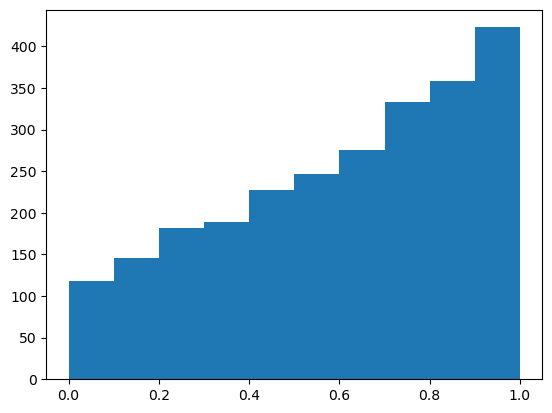

In [29]:
n=plt.hist(p_values_nonex1)
print(sc.stats.chisquare(n[0]))

Power_divergenceResult(statistic=102.26050420168067, pvalue=5.486506912422387e-18)


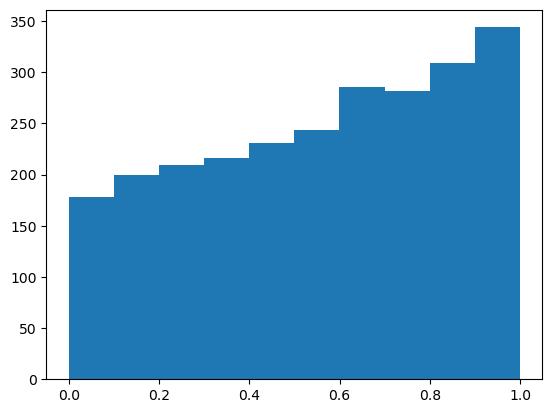

In [30]:
n = plt.hist(p_values_nonex2)
print(sc.stats.chisquare(n[0]))

Power_divergenceResult(statistic=17.578631452581035, pvalue=0.04038907927779068)


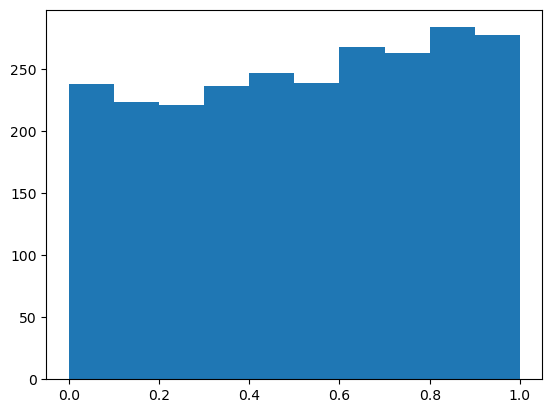

In [31]:
n = plt.hist(p_values_nonex3)
print(sc.stats.chisquare(n[0]))

In [32]:
p_values_nonex4 = np.array([])
distr_nx4 = np.array([])


for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    #weights = np.power(0.98,np.arange(0,len(scores)))
    #weights = np.flip(weights)
    #weights = weights/(np.sum(weights)+1)
    weights = np.empty((len(scores)))
    for j in range(len(scores)):
        weights[j]=1/(1+np.exp(-j+len(scores)-100))
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx4 = np.array([distr_nonex])
    else:
        distr_nx4 = np.concatenate((distr_nx4,np.array([distr_nonex])),axis=0)
    p_values_nonex4 = np.r_[p_values_nonex4, p_nonex]

/tmp/ipykernel_152548/4060447667.py:12: RuntimeWarning: overflow encountered in exp
  weights[j]=1/(1+np.exp(-j+len(scores)-100))


Power_divergenceResult(statistic=30.535814325730293, pvalue=0.00035548249317518034)


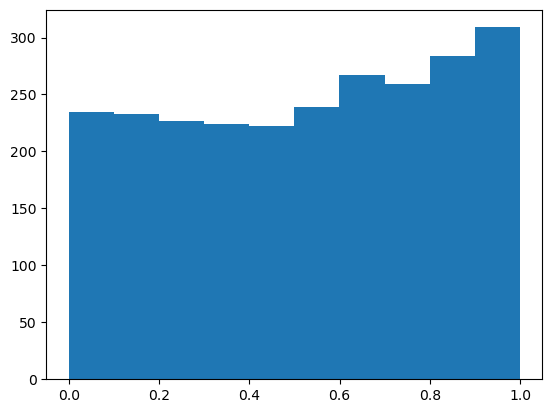

In [33]:
n = plt.hist(p_values_nonex4)
print(sc.stats.chisquare(n[0]))

In [34]:
p_values_nonex5 = np.array([])
distr_nx5 = np.array([])


for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    #weights = np.power(0.98,np.arange(0,len(scores)))
    #weights = np.flip(weights)
    #weights = weights/(np.sum(weights)+1)
    weights = np.empty((len(scores)))
    for j in range(len(scores)):
        weights[j]=1/(1+np.exp(-j+len(scores)-80))
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx5 = np.array([distr_nonex])
    else:
        distr_nx5 = np.concatenate((distr_nx5,np.array([distr_nonex])),axis=0)
    p_values_nonex5 = np.r_[p_values_nonex5, p_nonex]

/tmp/ipykernel_152548/3723963062.py:12: RuntimeWarning: overflow encountered in exp
  weights[j]=1/(1+np.exp(-j+len(scores)-80))


Power_divergenceResult(statistic=21.612244897959183, pvalue=0.010192558946116773)


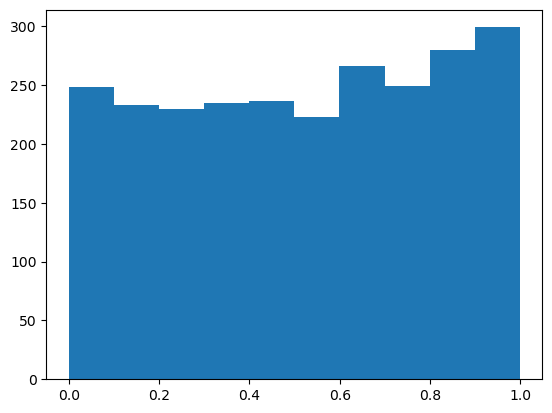

In [35]:
n = plt.hist(p_values_nonex5)
print(sc.stats.chisquare(n[0]))

In [36]:
p_values_nonex6 = np.array([])
distr_nx6 = np.array([])


for i in np.arange(500,len(param_drift)-1):
    model, scores = nonconfscores(drift_rand[:i])
    #weights = np.power(0.98,np.arange(0,len(scores)))
    #weights = np.flip(weights)
    #weights = weights/(np.sum(weights)+1)
    weights = np.empty((len(scores)))
    for j in range(len(scores)):
        weights[j]=1/(1+np.exp(-j+len(scores)-60))
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, drift_rand[i+1])
    if i == 500:
        distr_nx6 = np.array([distr_nonex])
    else:
        distr_nx6 = np.concatenate((distr_nx6,np.array([distr_nonex])),axis=0)
    p_values_nonex6 = np.r_[p_values_nonex6, p_nonex]

/tmp/ipykernel_152548/3129959049.py:12: RuntimeWarning: overflow encountered in exp
  weights[j]=1/(1+np.exp(-j+len(scores)-60))


Power_divergenceResult(statistic=15.513805522208884, pvalue=0.07775537159608908)


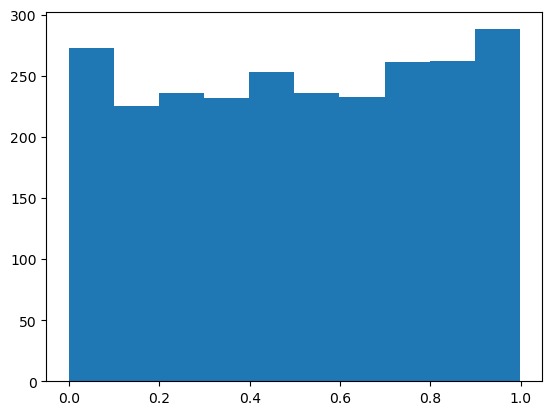

In [37]:
n = plt.hist(p_values_nonex6)
print(sc.stats.chisquare(n[0]))

In [38]:
distr_dist_nex = np.linalg.norm(label_distr.T-distr_nx,ord=2,axis=1)
distr_dist = np.linalg.norm(label_distr.T-distr_std,ord=2,axis=1)
distr_dist_nex1 = np.linalg.norm(label_distr.T-distr_nx1,ord=2,axis=1)
distr_dist_nex2 = np.linalg.norm(label_distr.T-distr_nx2,ord=2,axis=1)
distr_dist_nex3 = np.linalg.norm(label_distr.T-distr_nx3,ord=2,axis=1)
distr_dist_nex4 = np.linalg.norm(label_distr.T-distr_nx4,ord=2,axis=1)
distr_dist_nex6 = np.linalg.norm(label_distr.T-distr_nx6,ord=2,axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


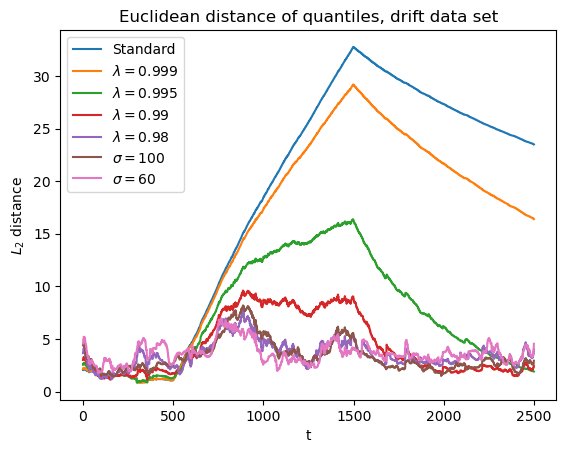

In [39]:
plt.plot(distr_dist,label='Standard')
plt.plot(distr_dist_nex,label = '$\lambda=0.999$')
plt.plot(distr_dist_nex1, label = '$\lambda=0.995$')
plt.plot(distr_dist_nex2, label = '$\lambda=0.99$')
plt.plot(distr_dist_nex3, label = '$\lambda=0.98$')
plt.plot(distr_dist_nex4, label = '$\sigma=100$')
plt.plot(distr_dist_nex6, label = '$\sigma=60$')
plt.legend()
plt.title('Euclidean distance of quantiles, drift data set')
plt.xlabel('t')
plt.ylabel('$L_2$ distance')
plt.savefig('drift.eps', format='eps')

In [40]:
mean_crps_nx_dr, crps_nx_dr = crps(distr_nx, drift_rand[501:])
mean_crps_std_dr, crps_std_dr = crps(distr_std, drift_rand[501:])
mean_crps_nx1_dr, crps_nx1_dr = crps(distr_nx1, drift_rand[501:])
mean_crps_nx2_dr, crps_nx2_dr = crps(distr_nx2, drift_rand[501:])
mean_crps_nx3_dr, crps_nx3_dr = crps(distr_nx3, drift_rand[501:])
mean_crps_label_dr, crps_label_dr = crps(label_distr.T, drift_rand[501:])
mean_crps_nx4_dr, crps_nx4_dr = crps(distr_nx4, drift_rand[501:])
mean_crps_nx6_dr, crps_nx6_dr = crps(distr_nx6, drift_rand[501:])

In [41]:
print(mean_crps_std_dr)
print(mean_crps_nx_dr)
print(mean_crps_nx1_dr)
print(mean_crps_nx2_dr)
print(mean_crps_nx3_dr)
print(mean_crps_nx4_dr)
print(mean_crps_nx6_dr)
print(mean_crps_label_dr)

1.014469638779588
0.8758858521570658
0.629810855754285
0.5691660514159361
0.5419372157933948
0.5381410630535517
0.5186276841387633
0.5467273545111141


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


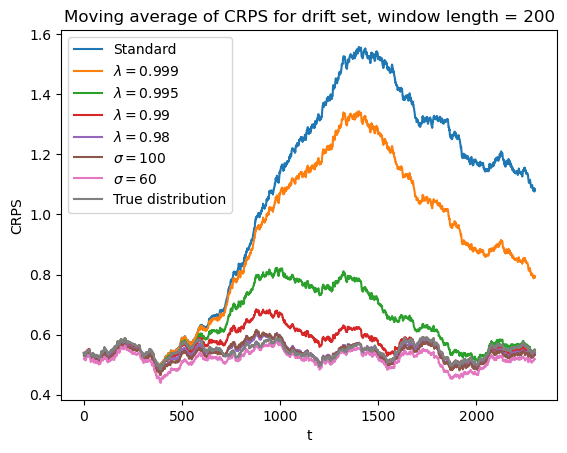

In [42]:
window = 200
plt.plot(movingaverage(crps_std_dr,window),label='Standard')
plt.plot(movingaverage(crps_nx_dr,window),label = '$\lambda=0.999$')
plt.plot(movingaverage(crps_nx1_dr,window), label = '$\lambda=0.995$')
plt.plot(movingaverage(crps_nx2_dr,window), label = '$\lambda=0.99$')
plt.plot(movingaverage(crps_nx3_dr,window), label = '$\lambda=0.98$')
plt.plot(movingaverage(crps_nx4_dr,window), label = '$\sigma=100$')
plt.plot(movingaverage(crps_nx6_dr,window), label = '$\sigma=60$')
plt.plot(movingaverage(crps_label_dr,window), label = 'True distribution')
plt.legend()
plt.xlabel('t')
plt.ylabel('CRPS')
plt.title(f'Moving average of CRPS for drift set, window length = {window}')
plt.savefig('drift_crps.eps', format='eps')

In [43]:
pl_mart = plugin_martingale(p_values)
pl_mart1 = plugin_martingale(p_values_nonex)
pl_mart2 = plugin_martingale(p_values_nonex1)
pl_mart3 = plugin_martingale(p_values_nonex2)
pl_mart4 = plugin_martingale(p_values_nonex3)
pl_mart5 = plugin_martingale(p_values_nonex4)
pl_mart6 = plugin_martingale(p_values_nonex6)

/tmp/ipykernel_152548/1551043480.py:7: RuntimeWarning: overflow encountered in exp
  plugin_martingale = [np.exp(m) for m in log_plugin_martingale]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


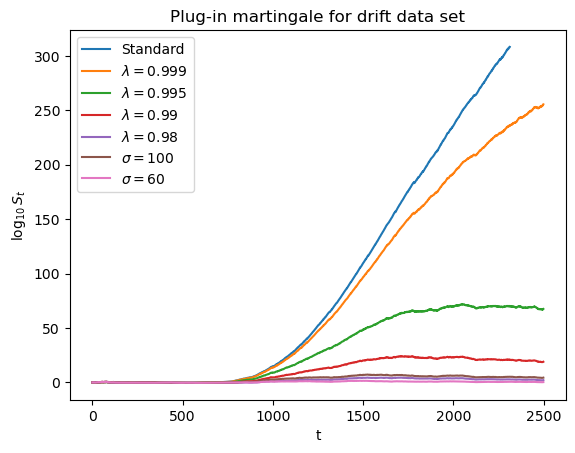

In [44]:
plt.plot([i for i in range(len(pl_mart))], [np.log10(m) for m in pl_mart],label='Standard')
plt.plot([i for i in range(len(pl_mart1))], [np.log10(m) for m in pl_mart1],label = '$\lambda=0.999$')
plt.plot([i for i in range(len(pl_mart2))], [np.log10(m) for m in pl_mart2],label = '$\lambda=0.995$')
plt.plot([i for i in range(len(pl_mart3))], [np.log10(m) for m in pl_mart3],label = '$\lambda=0.99$')
plt.plot([i for i in range(len(pl_mart4))], [np.log10(m) for m in pl_mart4],label = '$\lambda=0.98$')
plt.plot([i for i in range(len(pl_mart5))], [np.log10(m) for m in pl_mart5],label = '$\sigma=100$')
plt.plot([i for i in range(len(pl_mart6))], [np.log10(m) for m in pl_mart6],label = '$\sigma=60$')

plt.legend()
plt.title('Plug-in martingale for drift data set')
plt.ylabel('$\log_{10}S_t$')
plt.xlabel('t')
plt.savefig('drift_martingale.eps', format='eps')

In [45]:
print(pl_mart[-1])
print(pl_mart1[-1])
print(pl_mart2[-1])
print(pl_mart3[-1])
print(pl_mart4[-1])
print(pl_mart5[-1])
print(pl_mart6[-1])

inf
2.5560784759927427e+255
2.9837021613248075e+67
9.53263583876469e+18
129.3105549165133
24499.822830639136
1.9640958028052082


(0.0, 10000.0)

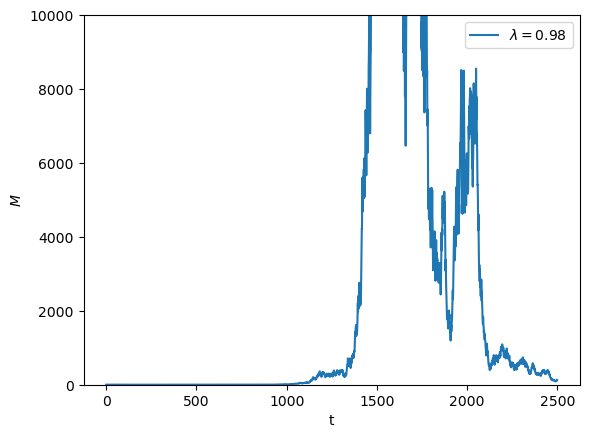

In [46]:
plt.plot([i for i in range(len(pl_mart4))], [m for m in pl_mart4],label = '$\lambda=0.98$')
plt.legend()
plt.ylabel('$M$')
plt.xlabel('t')
plt.ylim([0,10000])

In [47]:
p_values_sh = np.array([])
p_values_nonex_sh = np.array([])
distr_nx_sh = np.array([])
distr_std_sh = np.array([])
label_distr_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.power(0.999,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr2(model,scores,weights)
    p_val = p_value(model,scores,step_rand[i+1])
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx_sh = np.array([distr_nonex])
        distr_std_sh = np.array([distr])
        label_distr_sh = np.reshape(sc.stats.norm.ppf(np.linspace(0.001, 0.999,200),param_step[i+1]),(-1,1))
    else:
        distr_nx_sh = np.concatenate((distr_nx_sh,np.array([distr_nonex])),axis=0)
        distr_std_sh = np.concatenate((distr_std_sh,np.array([distr])),axis=0)
        label_distr_sh = np.concatenate((label_distr_sh,np.reshape(sc.stats.norm.ppf(np.linspace(0.001, 0.999,200),param_step[i+1]),(-1,1))),axis=1)
    
    p_values_sh = np.r_[p_values_sh, p_val]
    p_values_nonex_sh = np.r_[p_values_nonex_sh, p_nonex]

Power_divergenceResult(statistic=1101.633755837225, pvalue=2.0602209926599034e-231)


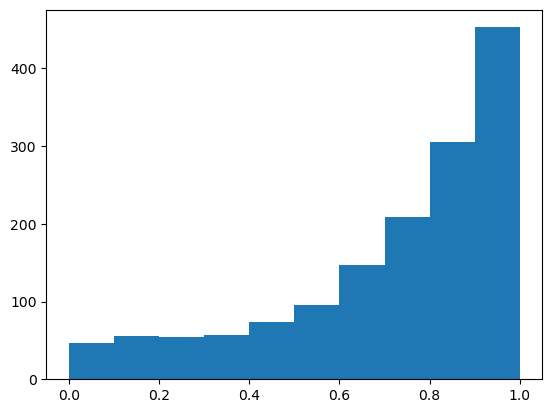

In [48]:
n=plt.hist(p_values_sh)
print(sc.stats.chisquare(n[0]))

Power_divergenceResult(statistic=772.4676450967311, pvalue=1.790841233830197e-160)


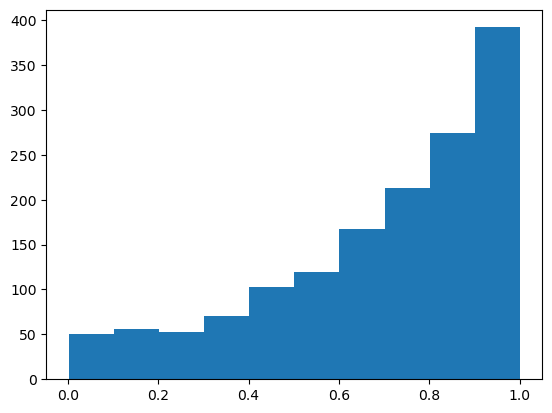

In [49]:
n=plt.hist(p_values_nonex_sh)
print(sc.stats.chisquare(n[0]))

In [50]:
p_values_nonex1_sh = np.array([])
distr_nx1_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.power(0.995,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx1_sh = np.array([distr_nonex])
    else:
        distr_nx1_sh = np.concatenate((distr_nx1_sh,np.array([distr_nonex])),axis=0)
    p_values_nonex1_sh = np.r_[p_values_nonex1_sh, p_nonex]

Power_divergenceResult(statistic=235.9499666444296, pvalue=9.17701865939946e-46)


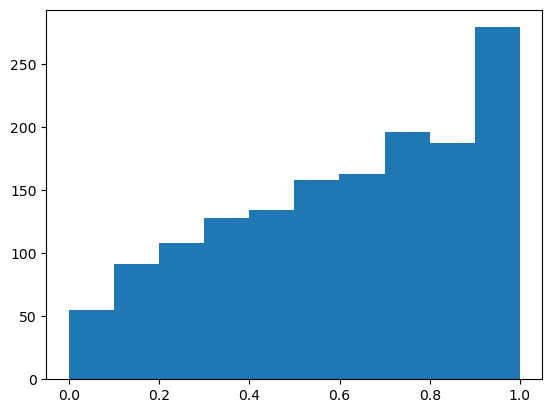

In [51]:
n = plt.hist(p_values_nonex1_sh)
print(sc.stats.chisquare(n[0]))

In [52]:
p_values_nonex2_sh = np.array([])
distr_nx2_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.power(0.99,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx2_sh = np.array([distr_nonex])
    else:
        distr_nx2_sh = np.concatenate((distr_nx2_sh,np.array([distr_nonex])),axis=0)
    p_values_nonex2_sh = np.r_[p_values_nonex2_sh, p_nonex]

Power_divergenceResult(statistic=76.29686457638425, pvalue=8.759361133869994e-13)


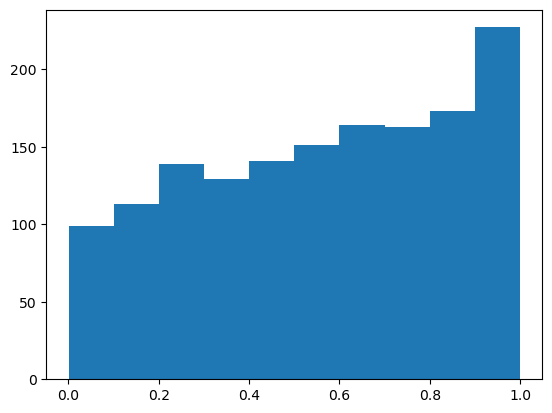

In [53]:
n = plt.hist(p_values_nonex2_sh)
print(sc.stats.chisquare(n[0]))

In [54]:
p_values_nonex3_sh = np.array([])
distr_nx3_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.power(0.98,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx3_sh = np.array([distr_nonex])
    else:
        distr_nx3_sh = np.concatenate((distr_nx3_sh,np.array([distr_nonex])),axis=0)
    p_values_nonex3_sh = np.r_[p_values_nonex3_sh, p_nonex]

Power_divergenceResult(statistic=17.6310873915944, pvalue=0.03970298041173135)


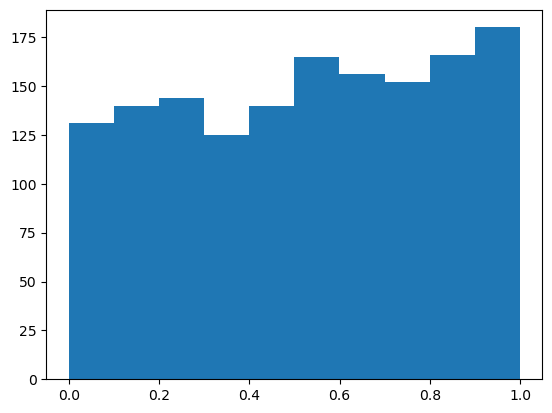

In [55]:
n = plt.hist(p_values_nonex3_sh)
print(sc.stats.chisquare(n[0]))

In [56]:
p_values_nonex4_sh = np.array([])
distr_nx4_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.empty((len(scores)))
    for j in range(len(scores)):
        weights[j]=1/(1+np.exp(-j+len(scores)-100))
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx4_sh = np.array([distr_nonex])
    else:
        distr_nx4_sh = np.concatenate((distr_nx4_sh,np.array([distr_nonex])),axis=0)
    p_values_nonex4_sh = np.r_[p_values_nonex4_sh, p_nonex]

/tmp/ipykernel_152548/2880762495.py:8: RuntimeWarning: overflow encountered in exp
  weights[j]=1/(1+np.exp(-j+len(scores)-100))


Power_divergenceResult(statistic=40.31287525016678, pvalue=6.668117118432175e-06)


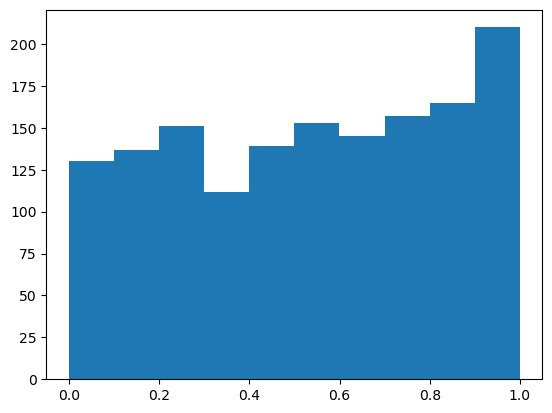

In [57]:
n = plt.hist(p_values_nonex4_sh)
print(sc.stats.chisquare(n[0]))

In [58]:
p_values_nonex5_sh = np.array([])
distr_nx5_sh = np.array([])

for i in np.arange(500,len(param_step)-1):
    model, scores = nonconfscores(step_rand[:i])
    weights = np.empty((len(scores)))
    for j in range(len(scores)):
        weights[j]=1/(1+np.exp(-j+len(scores)-60))
    weights = weights/(np.sum(weights)+1)
    distr_nonex, distr = predict_distr(model,scores,weights)
    p_nonex = p_value_nonex(model, scores, weights, step_rand[i+1])
    if i == 500:
        distr_nx5_sh = np.array([distr_nonex])
    else:
        distr_nx5_sh = np.concatenate((distr_nx5_sh,np.array([distr_nonex])),axis=0)
    p_values_nonex5_sh = np.r_[p_values_nonex5_sh, p_nonex]

/tmp/ipykernel_152548/138481517.py:8: RuntimeWarning: overflow encountered in exp
  weights[j]=1/(1+np.exp(-j+len(scores)-60))


Power_divergenceResult(statistic=14.135423615743829, pvalue=0.11758883692417352)


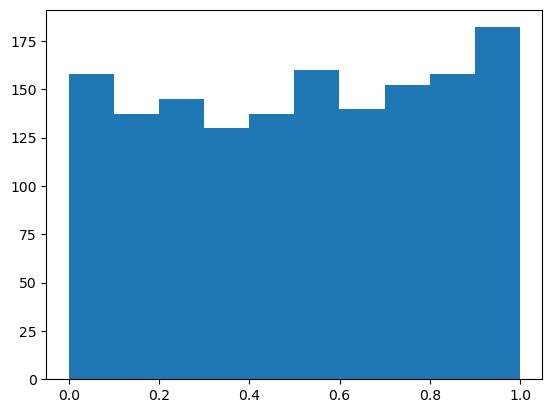

In [59]:
n = plt.hist(p_values_nonex5_sh)
print(sc.stats.chisquare(n[0]))

In [60]:
distr_dist_nex_sh = np.linalg.norm(label_distr_sh.T-distr_nx_sh,ord=2,axis=1)
distr_dist_sh = np.linalg.norm(label_distr_sh.T-distr_std_sh,ord=2,axis=1)
distr_dist_nex1_sh = np.linalg.norm(label_distr_sh.T-distr_nx1_sh,ord=2,axis=1)
distr_dist_nex2_sh = np.linalg.norm(label_distr_sh.T-distr_nx2_sh,ord=2,axis=1)
distr_dist_nex3_sh = np.linalg.norm(label_distr_sh.T-distr_nx3_sh,ord=2,axis=1)
distr_dist_nex4_sh = np.linalg.norm(label_distr_sh.T-distr_nx4_sh,ord=2,axis=1)
distr_dist_nex5_sh = np.linalg.norm(label_distr_sh.T-distr_nx5_sh,ord=2,axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


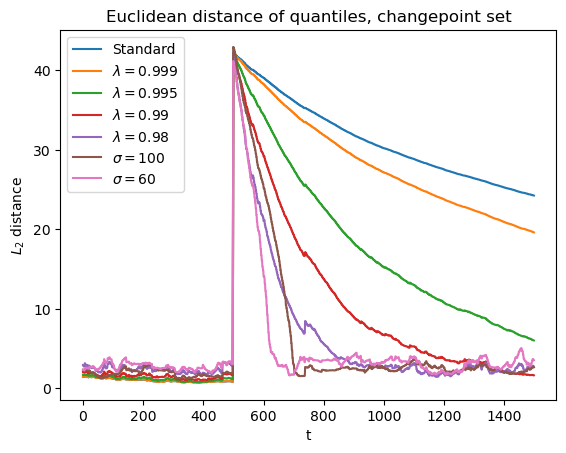

In [61]:
plt.plot(distr_dist_sh,label='Standard')
plt.plot(distr_dist_nex_sh,label = '$\lambda=0.999$')
plt.plot(distr_dist_nex1_sh, label = '$\lambda=0.995$')
plt.plot(distr_dist_nex2_sh, label = '$\lambda=0.99$')
plt.plot(distr_dist_nex3_sh, label = '$\lambda=0.98$')
plt.plot(distr_dist_nex4_sh, label = '$\sigma=100$')
plt.plot(distr_dist_nex5_sh, label = '$\sigma=60$')
plt.legend()
plt.title('Euclidean distance of quantiles, changepoint set')
plt.xlabel('t')
plt.ylabel('$L_2$ distance')
plt.savefig('step.eps', format='eps')
plt.savefig('chp.eps', format='eps')

In [62]:
mean_crps_nx_sh, crps_nx_sh = crps(distr_nx_sh, step_rand[501:])
mean_crps_std_sh, crps_std_sh = crps(distr_std_sh, step_rand[501:])
mean_crps_nx1_sh, crps_nx1_sh = crps(distr_nx1_sh, step_rand[501:])
mean_crps_nx2_sh, crps_nx2_sh = crps(distr_nx2_sh, step_rand[501:])
mean_crps_nx3_sh, crps_nx3_sh = crps(distr_nx3_sh, step_rand[501:])
mean_crps_nx4_sh, crps_nx4_sh = crps(distr_nx4_sh, step_rand[501:])
mean_crps_nx5_sh, crps_nx5_sh = crps(distr_nx5_sh, step_rand[501:])
mean_crps_label_sh, crps_label_sh = crps(label_distr_sh.T, step_rand[501:])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


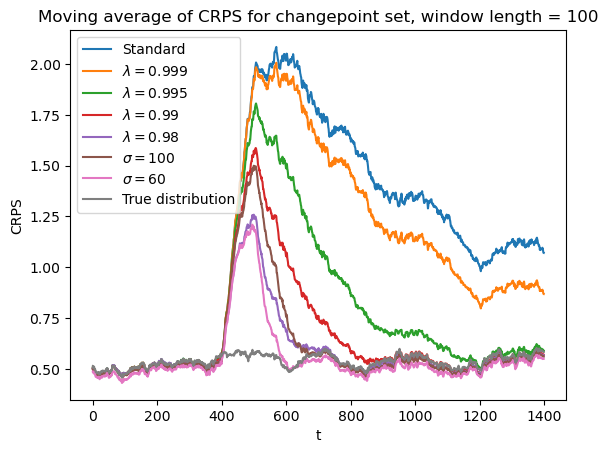

In [63]:
window = 100
plt.plot(movingaverage(crps_std_sh,window),label='Standard')
plt.plot(movingaverage(crps_nx_sh,window),label = '$\lambda=0.999$')
plt.plot(movingaverage(crps_nx1_sh,window), label = '$\lambda=0.995$')
plt.plot(movingaverage(crps_nx2_sh,window), label = '$\lambda=0.99$')
plt.plot(movingaverage(crps_nx3_sh,window), label = '$\lambda=0.98$')
plt.plot(movingaverage(crps_nx4_sh,window), label = '$\sigma=100$')
plt.plot(movingaverage(crps_nx5_sh,window), label = '$\sigma=60$')
plt.plot(movingaverage(crps_label_sh,window), label = 'True distribution')
plt.legend()
plt.xlabel('t')
plt.ylabel('CRPS')
plt.title(f'Moving average of CRPS for changepoint set, window length = {window}')
plt.savefig('chp_crps.eps', format='eps')

In [64]:
pl_mart_sh = plugin_martingale(p_values_sh)
pl_mart_sh1 = plugin_martingale(p_values_nonex_sh)
pl_mart_sh2 = plugin_martingale(p_values_nonex1_sh)
pl_mart_Sh3 = plugin_martingale(p_values_nonex2_sh)
pl_mart_sh4 = plugin_martingale(p_values_nonex3_sh)
pl_mart_sh5 = plugin_martingale(p_values_nonex4_sh)
pl_mart_sh6 = plugin_martingale(p_values_nonex5_sh)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


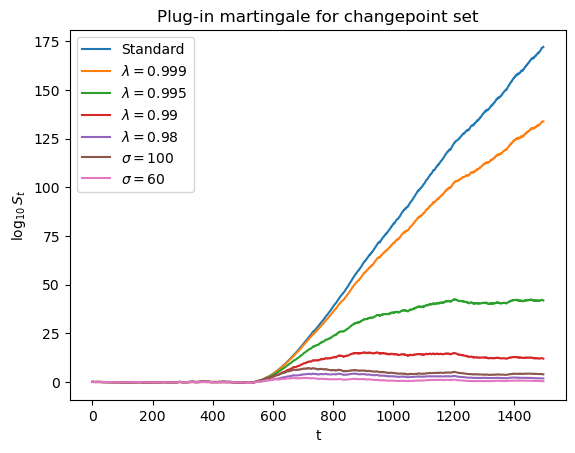

In [65]:
plt.plot([i for i in range(len(pl_mart_sh))], [np.log10(m) for m in pl_mart_sh],label='Standard')
plt.plot([i for i in range(len(pl_mart_sh1))], [np.log10(m) for m in pl_mart_sh1],label = '$\lambda=0.999$')
plt.plot([i for i in range(len(pl_mart_sh2))], [np.log10(m) for m in pl_mart_sh2],label = '$\lambda=0.995$')
plt.plot([i for i in range(len(pl_mart_Sh3))], [np.log10(m) for m in pl_mart_Sh3],label = '$\lambda=0.99$')
plt.plot([i for i in range(len(pl_mart_sh4))], [np.log10(m) for m in pl_mart_sh4],label = '$\lambda=0.98$')
plt.plot([i for i in range(len(pl_mart_sh5))], [np.log10(m) for m in pl_mart_sh5],label = '$\sigma=100$')
plt.plot([i for i in range(len(pl_mart_sh6))], [np.log10(m) for m in pl_mart_sh6],label = '$\sigma=60$')
plt.legend()
plt.title('Plug-in martingale for changepoint set')
plt.ylabel('$\log_{10}S_t$')
plt.xlabel('t')
plt.savefig('chp_martingale.eps', format='eps')

In [66]:
print(pl_mart_sh[-1])
print(pl_mart_sh1[-1])
print(pl_mart_sh2[-1])
print(pl_mart_Sh3[-1])
print(pl_mart_sh4[-1])
print(pl_mart_sh5[-1])
print(pl_mart_sh6[-1])

1.1936701781227211e+172
6.306883714563068e+133
6.88857071480622e+41
903316221523.7246
56.78093669833318
7566.96140142156
2.2726560271673666


In [72]:
iid = rng.normal(size=2000)

In [73]:
p_values_iid = np.array([])
p_values_nonex_iid = np.array([])

for i in np.arange(500,len(iid)-1):
    model, scores = nonconfscores(iid[:i])
    weights = np.power(0.999,np.arange(0,len(scores)))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    p_val = p_value(model,scores,iid[i+1])
    p_nonex = p_value_nonex(model, scores, weights, iid[i+1])
    p_values_iid = np.r_[p_values_iid, p_val]
    p_values_nonex_iid = np.r_[p_values_nonex_iid, p_nonex]

In [74]:
pl_mart_iid = plugin_martingale(p_values_iid)
pl_mart_iid1 = plugin_martingale(p_values_nonex_iid)

Text(0.5, 0, 't')

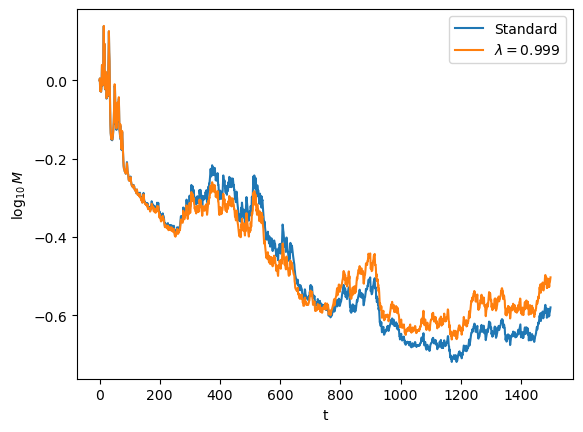

In [75]:
plt.plot([i for i in range(len(pl_mart_iid))], [np.log10(m) for m in pl_mart_iid],label='Standard')
plt.plot([i for i in range(len(pl_mart_iid1))], [np.log10(m) for m in pl_mart_iid1],label = '$\lambda=0.999$')
plt.legend()
plt.ylabel('$\log_{10}M$')
plt.xlabel('t')

In [67]:
import pandas as pd

<bound method NDFrame.head of            date  day    period  nswprice  nswdemand  vicprice  vicdemand  \
17778  0.442635    1  0.382979  0.070283   0.483190  0.004682   0.201450   
17779  0.442635    1  0.404255  0.089798   0.517108  0.005791   0.219575   
17780  0.442635    1  0.425532  0.089468   0.512943  0.005617   0.227602   
17781  0.442635    1  0.446809  0.101597   0.502231  0.006599   0.225531   
17782  0.442635    1  0.468085  0.095473   0.490925  0.006103   0.227084   
...         ...  ...       ...       ...        ...       ...        ...   
45283  0.915800    7  0.404255  0.077549   0.456263  0.005332   0.378560   
45284  0.915800    7  0.425532  0.074397   0.444213  0.005110   0.377525   
45285  0.915800    7  0.446809  0.059205   0.434692  0.004073   0.364837   
45286  0.915800    7  0.468085  0.072835   0.423386  0.005019   0.354480   
45287  0.915800    7  0.489362  0.058424   0.404790  0.004026   0.333506   

       transfer class  
17778  0.707456  DOWN  
17779  0.

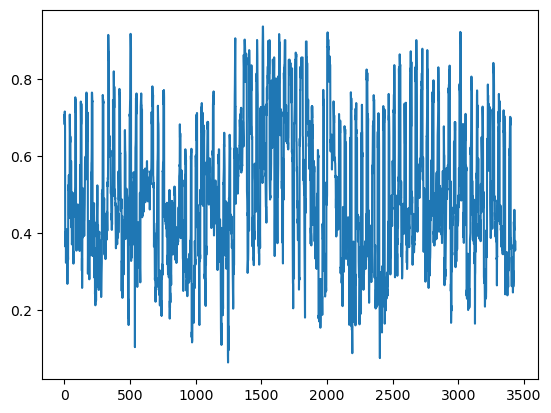

In [94]:
dataset = pd.read_csv('archive/electricity-normalized.csv')
dataset = dataset.loc[dataset['transfer']!=0.414912]
dataset = dataset.loc[dataset['transfer']!=0.500526]
# 09:00 0.382979, 12:00 0.510538
dataset = dataset.loc[(dataset['period'] >= 0.382979) & (dataset['period'] <= 0.510538)]
print(dataset.head)
plt.plot(dataset['transfer'].values)

In [95]:
y = dataset['transfer'].to_numpy()
x = dataset[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].to_numpy()
x = np.concatenate((np.ones((x.shape[0],1)), x), axis=1)
print(x.shape)

(3434, 5)


In [96]:
b, res, rank, s = np.linalg.lstsq(x,y)
print(b.shape)

(5,)


/tmp/ipykernel_75936/4078932126.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(x,y)


In [97]:
def predictions(x,y,lam,start_length):
    p_nonex_vals = np.array([])
    p_vals = np.array([])
    distr_nx = np.array([])
    distr_std = np.array([])
    preds = np.array([])
    for i in np.arange(start_length,len(y)-1):
        train_x, calib_x = x[0:i:2,:], x[1:i:2,:]
        train_y, calib_y = y[0:i:2], y[1:i:2]
        b, res, rank, s = np.linalg.lstsq(train_x,train_y)
        alpha = calib_y - b@calib_x.T
        pred = b@x[i+1,:]
        if pred > 1 or pred < 0:
            print(f'pred = {pred}, i = {i}, b = {b}, x = {x[i+1,:]}')
        preds = np.r_[preds,pred]
        weights = np.power(lam,np.arange(0,len(alpha)))
        weights = np.flip(weights)
        weights = weights/(np.sum(weights)+1)
        p_nonex = p_value_nonex(pred, alpha, weights, y[i+1])
        p_nonex_vals = np.r_[p_nonex_vals, p_nonex]
        p_val = p_value(pred, alpha,y[i+1])
        p_vals = np.r_[p_vals, p_val]
        distr_nonex, distr = predict_distr(pred,alpha,weights)
        if i == start_length:
            distr_nx = np.array([distr_nonex])
            distr_std= np.array([distr])
        else:
            distr_nx = np.concatenate((distr_nx,np.array([distr_nonex])),axis=0)
            distr_std = np.concatenate((distr_std,np.array([distr])),axis=0)
            
    return p_nonex_vals, p_vals, distr_nx, distr_std, preds
        

In [98]:
p_nonex_vals, p_vals, distr_nx, distr_std, pred = predictions(x,y,0.999,400)

/tmp/ipykernel_75936/4292641087.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(train_x,train_y)


pred = -0.0038281212847159907, i = 1024, b = [   0.55789543    6.67965748    0.68200109 -115.06250965   -0.85933376], x = [1.       0.392758 0.525439 0.027958 0.380114]
pred = -0.0026686394219290754, i = 1025, b = [   0.55731416    6.77432017    0.67861302 -116.51258495   -0.85461092], x = [1.       0.384022 0.518298 0.027399 0.375453]
pred = -0.1622545471214898, i = 1190, b = [   0.58724496    7.24047516    0.61172428 -120.39870211   -0.8569217 ], x = [1.       0.508917 0.704255 0.034804 0.787416]
pred = -0.04857591361995217, i = 1191, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.396421 0.711098 0.027083 0.819524]
pred = -0.45396654588956054, i = 1192, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.852738 0.728355 0.058134 0.831434]
pred = -0.3976954887376154, i = 1193, b = [   0.58241569    7.67732768    0.59837406 -124.48625932   -0.84858496], x = [1.       0.870181 0.748735 0.059474 0.8309

In [99]:
p_nonex_vals1, p_v, distr_nx1, d_std, pred = predictions(x,y,0.99,400)

/tmp/ipykernel_75936/4292641087.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(train_x,train_y)


pred = -0.0038281212847159907, i = 1024, b = [   0.55789543    6.67965748    0.68200109 -115.06250965   -0.85933376], x = [1.       0.392758 0.525439 0.027958 0.380114]
pred = -0.0026686394219290754, i = 1025, b = [   0.55731416    6.77432017    0.67861302 -116.51258495   -0.85461092], x = [1.       0.384022 0.518298 0.027399 0.375453]
pred = -0.1622545471214898, i = 1190, b = [   0.58724496    7.24047516    0.61172428 -120.39870211   -0.8569217 ], x = [1.       0.508917 0.704255 0.034804 0.787416]
pred = -0.04857591361995217, i = 1191, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.396421 0.711098 0.027083 0.819524]
pred = -0.45396654588956054, i = 1192, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.852738 0.728355 0.058134 0.831434]
pred = -0.3976954887376154, i = 1193, b = [   0.58241569    7.67732768    0.59837406 -124.48625932   -0.84858496], x = [1.       0.870181 0.748735 0.059474 0.8309

In [100]:
p_nonex_vals2, p_v, distr_nx2, d_std, pred = predictions(x,y,0.98,400)

/tmp/ipykernel_75936/4292641087.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(train_x,train_y)


pred = -0.0038281212847159907, i = 1024, b = [   0.55789543    6.67965748    0.68200109 -115.06250965   -0.85933376], x = [1.       0.392758 0.525439 0.027958 0.380114]
pred = -0.0026686394219290754, i = 1025, b = [   0.55731416    6.77432017    0.67861302 -116.51258495   -0.85461092], x = [1.       0.384022 0.518298 0.027399 0.375453]
pred = -0.1622545471214898, i = 1190, b = [   0.58724496    7.24047516    0.61172428 -120.39870211   -0.8569217 ], x = [1.       0.508917 0.704255 0.034804 0.787416]
pred = -0.04857591361995217, i = 1191, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.396421 0.711098 0.027083 0.819524]
pred = -0.45396654588956054, i = 1192, b = [   0.58528882    7.44761527    0.60645037 -122.51342371   -0.85350816], x = [1.       0.852738 0.728355 0.058134 0.831434]
pred = -0.3976954887376154, i = 1193, b = [   0.58241569    7.67732768    0.59837406 -124.48625932   -0.84858496], x = [1.       0.870181 0.748735 0.059474 0.8309

In [101]:
pl_mart = plugin_martingale(p_vals)
pl_mart_nx = plugin_martingale(p_nonex_vals)

In [102]:
pl_mart_nx1 = plugin_martingale(p_nonex_vals1)
pl_mart_nx2 = plugin_martingale(p_nonex_vals2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


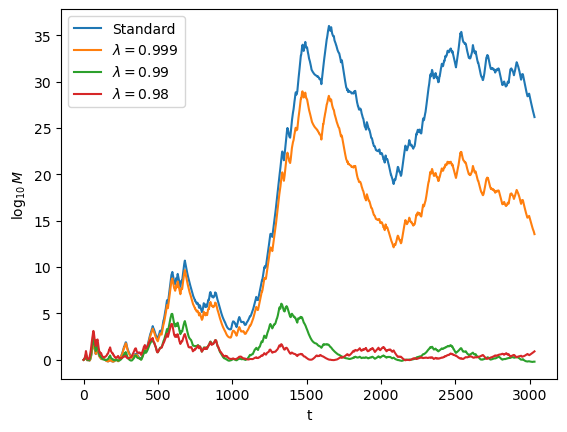

In [114]:
plt.plot([i for i in range(len(pl_mart))], [np.log10(m) for m in pl_mart],label='Standard')
plt.plot([i for i in range(len(pl_mart_nx))], [np.log10(m) for m in pl_mart_nx],label = '$\lambda=0.999$')
plt.plot([i for i in range(len(pl_mart_nx1))], [np.log10(m) for m in pl_mart_nx1],label = '$\lambda=0.99$')
plt.plot([i for i in range(len(pl_mart_nx2))], [np.log10(m) for m in pl_mart_nx2],label = '$\lambda=0.98$')
plt.legend()
plt.ylabel('$\log_{10}M$')
plt.xlabel('t')
plt.savefig('elec2_martingale.eps', format='eps')

In [104]:
labels = y[401:]

In [105]:
mean_crps_nx, crps_nx = crps(distr_nx, labels)
mean_crps_std, crps_std = crps(distr_std, labels)
mean_crps_nx1, crps_nx1 = crps(distr_nx1, labels)
mean_crps_nx2, crps_nx2 = crps(distr_nx2, labels)

In [106]:
print(mean_crps_std)
print(mean_crps_nx)
print(mean_crps_nx1)
print(mean_crps_nx2)

0.07373934913819513
0.07267985698359426
0.06477051339989656
0.05996402747876252


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


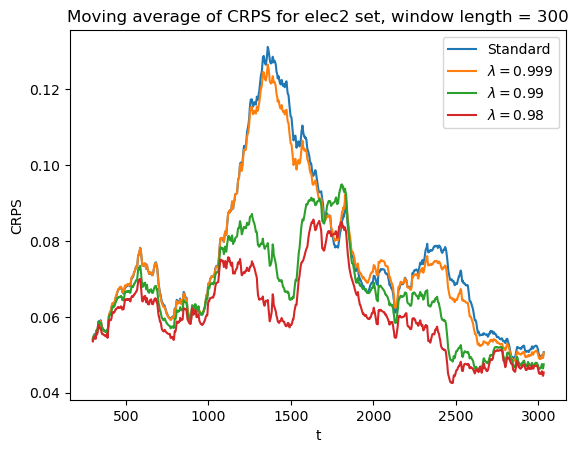

In [115]:
window = 300
plt.plot(np.arange(window,len(crps_std)),movingaverage(crps_std,window),label='Standard')
plt.plot(np.arange(window,len(crps_nx)),movingaverage(crps_nx,window),label = '$\lambda=0.999$')
plt.plot(np.arange(window,len(crps_nx1)),movingaverage(crps_nx1,window),label = '$\lambda=0.99$')
plt.plot(np.arange(window,len(crps_nx2)),movingaverage(crps_nx2,window),label = '$\lambda=0.98$')
plt.legend()
plt.xlabel('t')
plt.ylabel('CRPS')
plt.title(f'Moving average of CRPS for elec2 set, window length = {window}')
plt.savefig('elec_crps.eps', format='eps')

In [68]:
data_loaded = np.load('days_data_GOKI.npy')

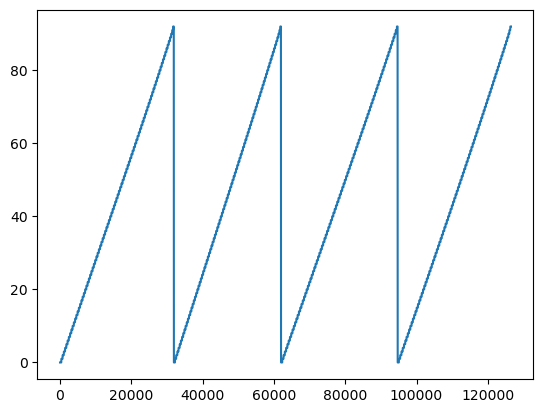

In [69]:
plt.plot(data_loaded)

In [70]:
data_loaded.shape

(126486,)

In [71]:
data_test = np.load('test_data_GOKI.npy')

In [72]:
data_test[0:3,:]

array([[-1.7040978 ,  0.20785402,  0.00778541,  1.50008036, -1.71230214,
         1.57826248,  1.66965863, -0.17881768, -0.98948406,  0.98948406,
        -0.79765927],
       [-1.7040978 ,  1.30723137,  0.60259634, -1.49863417, -1.71230214,
        -0.63360817, -1.81661102, -0.17881768,  1.0106277 , -1.0106277 ,
        -0.26251348],
       [-1.7040978 ,  2.01650709,  1.16171862, -0.99884841, -1.71230214,
        -0.63360817, -1.81661102, -0.17881768, -0.98948406,  0.98948406,
         0.26171097]])

In [73]:
df = pd.DataFrame(data_test)

In [74]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000,31795.000000
mean,-0.013696,0.178353,0.157073,-0.021959,0.016894,-0.033805,-0.000086,0.004326,-0.007199,0.007199,0.107096
std,0.999925,1.055450,1.089498,0.990696,0.985544,0.983338,0.983222,1.011648,0.999914,0.999914,1.035311
min,-1.704098,-1.068842,-1.074770,-1.498634,-1.712302,-0.633608,-1.816611,-0.178818,-0.989484,-1.010628,-1.442018
25%,-0.876024,-0.607813,-0.646507,-0.998848,-0.815620,-0.633608,-0.859596,-0.178818,-0.989484,-1.010628,-0.655682
50%,-0.010310,-0.111320,-0.170658,0.000723,0.081063,-0.633608,0.029061,-0.178818,-0.989484,0.989484,-0.175143
75%,0.855404,0.668883,0.626389,1.000295,0.977745,1.578262,0.849360,-0.178818,1.010628,0.989484,0.753171
max,1.758757,5.775668,5.753659,1.500080,1.575533,1.578262,1.669659,5.592288,1.010628,0.989484,4.411821


In [75]:
data_train = np.load('train_data_GOKI.npy')
df2 = pd.DataFrame(data_train)

In [76]:
print(data_train[:,10])

[-1.21267028 -0.32804153  0.86238481 ... -0.41541227 -0.28435616
  0.81869944]


In [77]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04,9.469100e+04
mean,1.920974e-17,3.841948e-17,7.203652e-17,3.699376e-17,-5.417747e-17,4.599832e-17,-3.031537e-17,3.883219e-18,-8.689405e-17,7.939025e-17,-1.208112e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.704098e+00,-1.068842e+00,-1.074770e+00,-1.498634e+00,-1.712302e+00,-6.336082e-01,-1.816611e+00,-1.788177e-01,-9.894841e-01,-1.010628e+00,-1.583996e+00
25%,-8.760238e-01,-7.496682e-01,-7.178839e-01,-9.988484e-01,-8.156198e-01,-6.336082e-01,-7.912376e-01,-1.788177e-01,-9.894841e-01,-1.010628e+00,-7.430526e-01
50%,-1.030997e-02,-3.241028e-01,-3.134125e-01,7.230956e-04,8.106261e-02,-6.336082e-01,2.906114e-02,-1.788177e-01,-9.894841e-01,9.894841e-01,-2.079068e-01
75%,8.554038e-01,4.561005e-01,4.122568e-01,1.000295e+00,9.777450e-01,1.578262e+00,8.493599e-01,-1.788177e-01,1.010628e+00,9.894841e-01,5.129018e-01
max,1.758757e+00,6.555872e+00,5.753659e+00,1.500080e+00,1.575533e+00,1.578262e+00,1.738017e+00,5.592288e+00,1.010628e+00,9.894841e-01,4.215237e+00


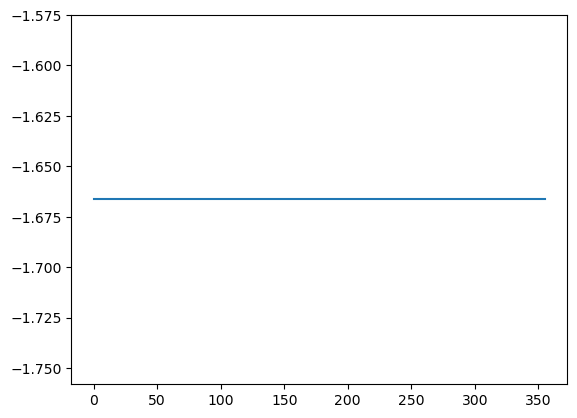

In [78]:
plt.plot(data_test[356:356+356,0])

In [79]:
data_test.shape[0]/356

89.31179775280899

In [80]:
vec = data_test[:,0]
b=-np.inf
lengths = np.array([])
for i in vec:
    if i != b:
        lengths = np.append(lengths, 1)
        b = i
    else:
        lengths[-1] += 1


In [81]:
len(lengths)
lengths

array([356., 356., 356., 356., 356., 356., 356., 356., 356., 356., 356.,
       356., 356., 355., 355., 355., 355., 355., 355., 354., 353., 353.,
       353., 353., 353., 353., 353., 352., 352., 352., 352., 352., 352.,
       350., 350., 350., 349., 349., 349., 349., 348., 347., 347., 347.,
       347., 347., 347., 346., 345., 345., 345., 345., 345., 345., 344.,
       343., 343., 343., 343., 342., 342., 341., 340., 340., 340., 340.,
       339., 339., 338., 336., 336., 336., 336., 336., 335., 334., 332.,
       332., 331., 331., 331., 331., 329., 327., 326., 326., 326., 326.,
       326., 324., 298., 250., 196.])

In [82]:
vec = data_train[:,0]
b=-np.inf
lengths2 = np.array([])
for i in vec:
    if i != b:
        lengths2 = np.append(lengths2, 1)
        b = i
    else:
        lengths2[-1] += 1

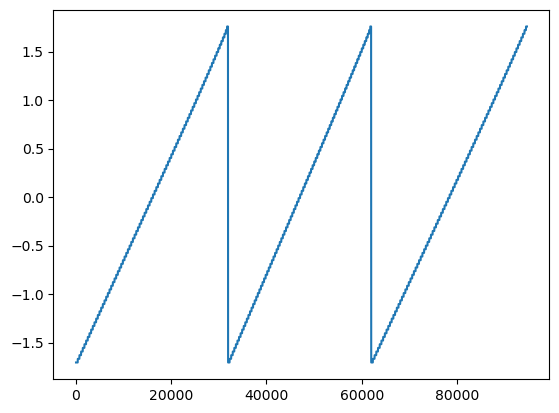

In [83]:
plt.plot(data_train[:,0])

In [84]:
print(len(lengths2)/3)
print(lengths2[:93])
print(lengths2[93:93+93])
print(lengths2[93+93:93+93+93])

93.0
[351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351.
 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351.
 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351. 351.
 351. 351. 350. 350. 350. 350. 350. 350. 350. 350. 350. 350. 350. 349.
 348. 348. 348. 347. 347. 347. 347. 346. 345. 345. 345. 344. 342. 342.
 342. 342. 340. 337. 337. 337. 337. 337. 335. 335. 332. 332. 330. 330.
 330. 328. 327. 327. 327. 326. 300. 257. 203.]
[329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329.
 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329.
 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329. 329.
 329. 329. 329. 329. 329. 329. 329. 328. 328. 328. 328. 327. 327. 327.
 327. 327. 327. 327. 327. 327. 326. 326. 326. 325. 325. 323. 323. 322.
 321. 321. 320. 320. 320. 320. 320. 320. 320. 318. 318. 318. 318. 318.
 318. 318. 317. 316. 314. 310. 285. 243. 191.]
[359. 359. 359. 359. 359. 359. 359. 359. 359. 359

In [85]:
start = 351*44+350*11+349+348*3+347
stop = start + 347
day = data_train[start+1,0]
ind_train = np.argwhere(data_train[:,0]==day)
ind_test = np.argwhere(data_test[:,0]==day)
x_train = data_train[ind_train,1:-1]
y_train = data_train[ind_train,-1]
x_test = data_test[ind_test,1:-1]
y_test = data_test[ind_test,-1]

x = np.append(np.reshape(x_train,(x_train.shape[0],x_train.shape[2])),np.reshape(x_test,(x_test.shape[0],x_train.shape[2])),axis=0)
y = np.append(y_train,y_test)

In [86]:
x.shape

(1370, 9)

In [87]:
from sklearn.ensemble import RandomForestRegressor

0 days before departure


1 ?

2 ?

3 day of the week

4 month

5 weekend

6 week

7 special event?

8 ferry identifier


9 ferry identifier (inverted)

10 target?

In [88]:
def exp_decay(length,lam):
    weights = np.power(lam,np.arange(0,length))
    weights = np.flip(weights)
    weights = weights/(np.sum(weights)+1)
    return weights

In [89]:
def sigmoid(length,center):
    weights = np.empty((length))
    for i in range(length):
        weights[i]=1/(1+np.exp(-i+length-center))
    weights = weights/(np.sum(weights)+1)
    return weights


In [90]:
def calibrate(x,y,w_func, param):
    x_train = x[::2,:]
    x_calib = x[1::2,:]
    y_train = y[::2]
    y_calib = y[1::2]
    model = RandomForestRegressor(random_state=2022).fit(X=x_train,y=y_train)
    prediction = model.predict(x_calib)
    resid = y_calib - prediction
    weights = w_func(len(resid),param)
    
    return model, resid, weights

In [91]:
model,alpha,weigths = calibrate(x,y,0.99)

TypeError: calibrate() missing 1 required positional argument: 'param'

In [92]:
plt.plot(alpha)

NameError: name 'alpha' is not defined

In [129]:
start_ind = 300
lam = 0.99
model,alpha,weights = calibrate(x[:start_ind,:],y[:start_ind],exp_decay,lam)
p_values_ne = np.empty((len(y)-start_ind))
p_values = np.empty((len(y)-start_ind))
pred_distr_ne = np.empty((len(y)-start_ind,200))
pred_distr= np.empty((len(y)-start_ind,200))
for i in np.arange(start_ind,len(y)):
    pred = model.predict(x[i,:].reshape(1,-1))
    p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
    p_values[i-start_ind] = p_value(pred,alpha,y[i])
    distr_ne,distr= predict_distr2(pred,alpha,weights)
    pred_distr_ne[i-start_ind,:] = distr_ne
    pred_distr[i-start_ind,:] = distr
    if i % 10 == 9:
        model,alpha,weights = calibrate(x[:i,:],y[:i],exp_decay,lam)
    

/tmp/ipykernel_152548/3498147430.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/3498147430.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/3498147430.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp

In [130]:
start_ind = 300
lam = 0.98
model,alpha,weights = calibrate(x[:start_ind,:],y[:start_ind],exp_decay,lam)
p_values_ne1 = np.empty((len(y)-start_ind))
p_values = np.empty((len(y)-start_ind))
pred_distr_ne1 = np.empty((len(y)-start_ind,200))
pred_distr= np.empty((len(y)-start_ind,200))
for i in np.arange(start_ind,len(y)):
    pred = model.predict(x[i,:].reshape(1,-1))
    p_values_ne1[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
    p_values[i-start_ind] = p_value(pred,alpha,y[i])
    distr_ne,distr= predict_distr2(pred,alpha,weights)
    pred_distr_ne1[i-start_ind,:] = distr_ne
    pred_distr[i-start_ind,:] = distr
    if i % 10 == 9:
        model,alpha,weights = calibrate(x[:i,:],y[:i],exp_decay,lam)

/tmp/ipykernel_152548/1308286285.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne1[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/1308286285.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne1[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/1308286285.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne1[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/

In [131]:
start_ind = 300
center = 100
model,alpha,weights = calibrate(x[:start_ind,:],y[:start_ind],sigmoid,center)
p_values_ne2 = np.empty((len(y)-start_ind))
pred_distr_ne2 = np.empty((len(y)-start_ind,200))
for i in np.arange(start_ind,len(y)):
    pred = model.predict(x[i,:].reshape(1,-1))
    p_values_ne2[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
    distr_ne,distr= predict_distr2(pred,alpha,weights)
    pred_distr_ne2[i-start_ind,:] = distr_ne
    if i % 10 == 9:
        model,alpha,weights = calibrate(x[:i,:],y[:i],sigmoid,center)

/tmp/ipykernel_152548/2111317414.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne2[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/2111317414.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne2[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/2111317414.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne2[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp

In [132]:
start_ind = 300
center = 60
model,alpha,weights = calibrate(x[:start_ind,:],y[:start_ind],sigmoid,center)
p_values_ne3 = np.empty((len(y)-start_ind))
#p_values = np.empty((len(y)-start_ind))
pred_distr_ne3 = np.empty((len(y)-start_ind,200))
#pred_distr= np.empty((len(y)-start_ind,200))
for i in np.arange(start_ind,len(y)):
    pred = model.predict(x[i,:].reshape(1,-1))
    p_values_ne3[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
    #p_values[i-start_ind] = p_value(pred,alpha,y[i])
    distr_ne,distr= predict_distr2(pred,alpha,weights)
    pred_distr_ne3[i-start_ind,:] = distr_ne
    #pred_distr[i-start_ind,:] = distr
    if i % 10 == 9:
        model,alpha,weights = calibrate(x[:i,:],y[:i],sigmoid,center)

/tmp/ipykernel_152548/956392807.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne3[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/956392807.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne3[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp/ipykernel_152548/956392807.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne3[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y[i])
/tmp

In [158]:
from quantile_forest import RandomForestQuantileRegressor
start_ind = 300
#center = 60
forest= RandomForestQuantileRegressor(n_estimators=200, random_state=2022).fit(x[:start_ind,:],y[:start_ind])
p_values_QRF = np.empty((len(y)-start_ind))
pred_distr_QRF = np.empty((len(y)-start_ind,200))
quantiles =np.linspace(0.001,0.999,200)
for i in np.arange(start_ind,len(y)):
    pred = forest.predict(x[i,:].reshape(1,-1), quantiles=quantiles.tolist())
    #print(pred.shape)
    if y[i] < pred[0,0]:
        p_values_QRF[i-start_ind] = quantiles[0]*rng.uniform()
    elif y[i] > pred[0,-1]:
        p_values_QRF[i-start_ind] = quantiles[-1] + rng.uniform()*(1-quantiles[-1])
    else:
        #print(quantiles[np.argwhere(pred[0,:] < y[i])])
        #if quantiles[np.argwhere(pred[0,:] < y[i])].size == 0:
        #    print(pred[0,:])
        #    print(y[i])
        ind = np.argwhere(pred[0,:] <= y[i])
        p_values_QRF[i-start_ind] = np.max(quantiles[ind]) + rng.uniform()*(quantiles[1]-quantiles[0])
    #p_values[i-start_ind] = p_value(pred,alpha,y[i])
    #distr_q= predict_distr2(pred,alpha,weights)
    pred_distr_QRF[i-start_ind,:] = pred
    #pred_distr[i-start_ind,:] = distr
    if i % 10 == 9:
        forest.fit(x[:i,:],y[:i])

In [159]:
print(np.argwhere(p_values_QRF > 1))

[]


(array([151., 170., 105.,  92.,  91., 103.,  97., 114.,  76.,  71.]),
 array([4.43653620e-04, 1.00338789e-01, 2.00233925e-01, 3.00129061e-01,
        4.00024197e-01, 4.99919332e-01, 5.99814468e-01, 6.99709604e-01,
        7.99604739e-01, 8.99499875e-01, 9.99395011e-01]),
 <BarContainer object of 10 artists>)

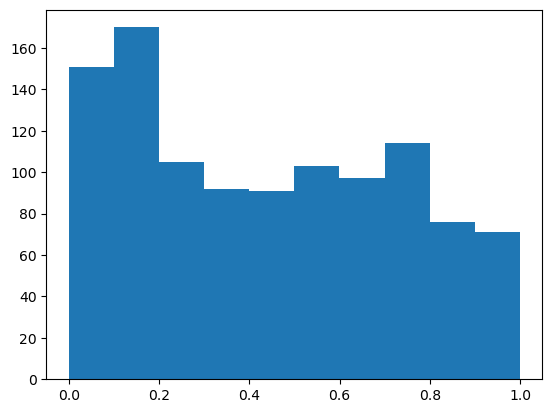

In [97]:
plt.hist(p_values)

(array([117., 150., 113.,  91., 102.,  89.,  96., 109.,  97., 106.]),
 array([1.21117303e-04, 9.96079082e-02, 1.99094699e-01, 2.98581490e-01,
        3.98068281e-01, 4.97555072e-01, 5.97041862e-01, 6.96528653e-01,
        7.96015444e-01, 8.95502235e-01, 9.94989026e-01]),
 <BarContainer object of 10 artists>)

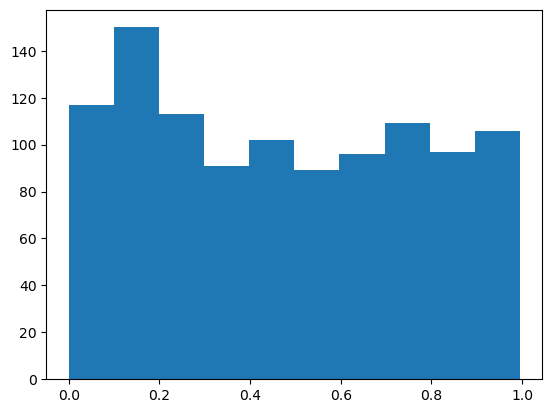

In [98]:
plt.hist(p_values_ne)

(array([116., 141., 111., 101.,  98.,  89.,  96., 110., 102., 106.]),
 array([7.42982379e-06, 9.97856422e-02, 1.99563855e-01, 2.99342067e-01,
        3.99120279e-01, 4.98898492e-01, 5.98676704e-01, 6.98454916e-01,
        7.98233129e-01, 8.98011341e-01, 9.97789553e-01]),
 <BarContainer object of 10 artists>)

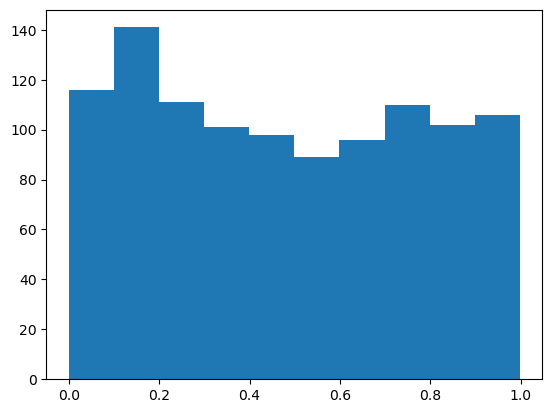

In [99]:
plt.hist(p_values_ne1)

(array([123., 129., 110.,  94., 107.,  78., 101., 101., 108., 119.]),
 array([3.92707228e-105, 9.97627218e-002, 1.99525444e-001, 2.99288166e-001,
        3.99050887e-001, 4.98813609e-001, 5.98576331e-001, 6.98339053e-001,
        7.98101775e-001, 8.97864497e-001, 9.97627218e-001]),
 <BarContainer object of 10 artists>)

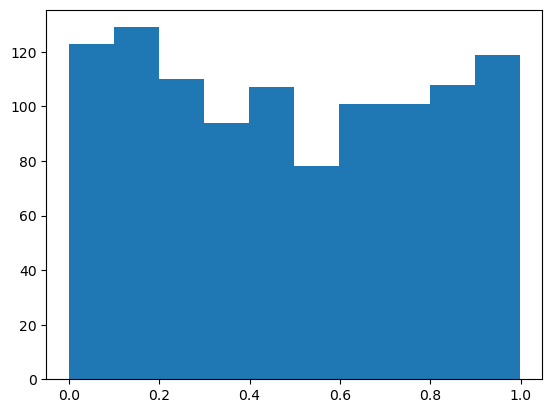

In [100]:
plt.hist(p_values_ne2)

(array([121., 136., 107., 103.,  91.,  97.,  84., 109., 103., 119.]),
 array([1.35884384e-121, 9.97773373e-002, 1.99554675e-001, 2.99332012e-001,
        3.99109349e-001, 4.98886687e-001, 5.98664024e-001, 6.98441361e-001,
        7.98218699e-001, 8.97996036e-001, 9.97773373e-001]),
 <BarContainer object of 10 artists>)

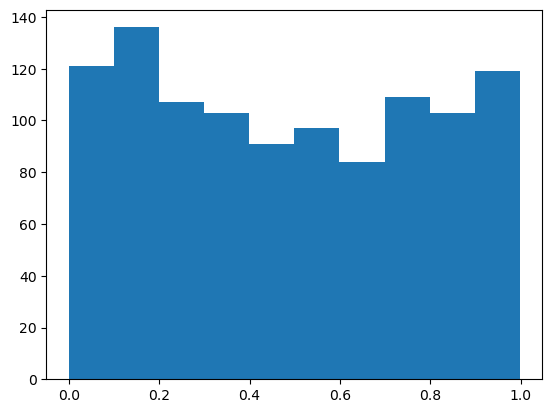

In [101]:
plt.hist(p_values_ne3)

(array([197., 117.,  90., 109., 100., 102.,  98.,  67.,  88., 102.]),
 array([1.25109364e-04, 1.00111095e-01, 2.00097081e-01, 3.00083066e-01,
        4.00069052e-01, 5.00055037e-01, 6.00041023e-01, 7.00027009e-01,
        8.00012994e-01, 8.99998980e-01, 9.99984966e-01]),
 <BarContainer object of 10 artists>)

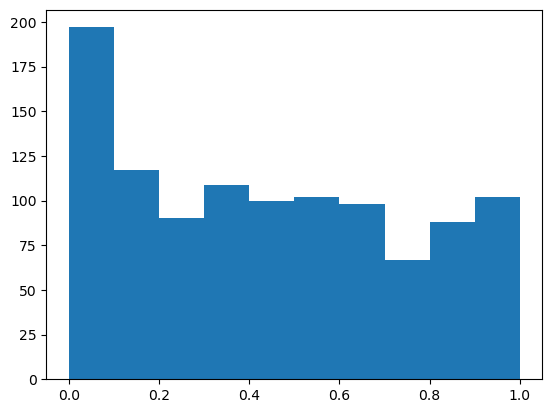

In [160]:
plt.hist(p_values_QRF)

In [161]:
martin1 = plugin_martingale(p_values)
martin_ne = plugin_martingale(p_values_ne)
martin_ne1 = plugin_martingale(p_values_ne1)
martin_ne2 = plugin_martingale(p_values_ne2)
martin_ne3 = plugin_martingale(p_values_ne3)
martin_QRF = plugin_martingale(p_values_QRF)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


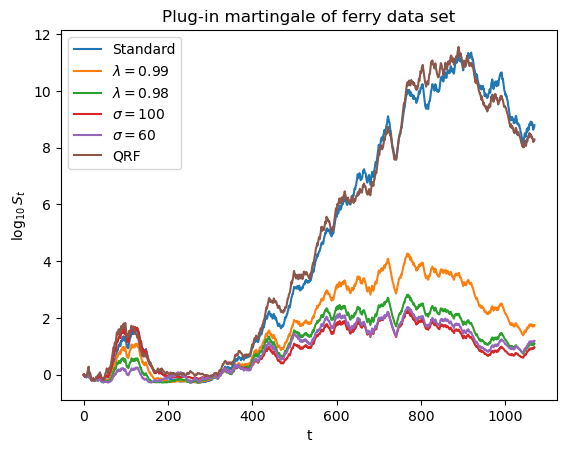

In [162]:
plt.plot([i for i in range(len(martin1))], [np.log10(m) for m in martin1],label='Standard')
plt.plot([i for i in range(len(martin_ne))], [np.log10(m) for m in martin_ne],label = '$\lambda=0.99$')
plt.plot([i for i in range(len(martin_ne1))], [np.log10(m) for m in martin_ne1],label = '$\lambda=0.98$')
plt.plot([i for i in range(len(martin_ne2))], [np.log10(m) for m in martin_ne2],label = '$\sigma=100$')
plt.plot([i for i in range(len(martin_ne3))], [np.log10(m) for m in martin_ne3],label = '$\sigma=60$')
plt.plot([i for i in range(len(martin_QRF))], [np.log10(m) for m in martin_QRF],label = 'QRF')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\log_{10}S_t$')
plt.title('Plug-in martingale of ferry data set')
plt.savefig('ferry_mart.eps', format='eps')

In [104]:
threshold = 100
i = 0
p_temp = p_values
mar = np.array(plugin_martingale(p_values))
i = np.argwhere(mar > threshold)[0]
print(i)
while i != None:
    mar[i[0]:] = np.array(plugin_martingale(p_values[i[0]:]))
    ind = np.argwhere(mar > threshold)
    if ind.size!=0:
        i = np.argwhere(mar > threshold)[0]
    else:
        break
    print(i)

[432]
[551]
[607]
[718]


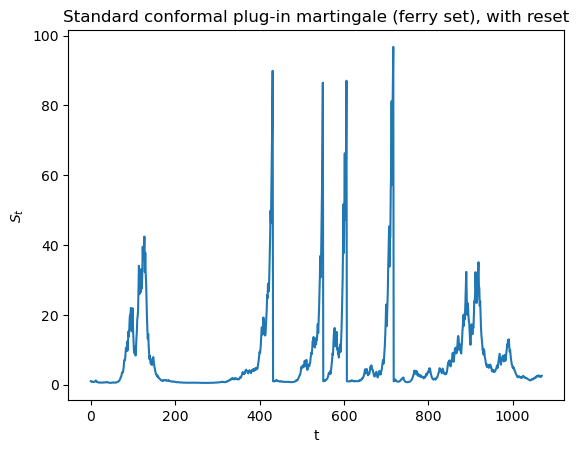

In [105]:
plt.plot(mar)
plt.title('Standard conformal plug-in martingale (ferry set), with reset')
plt.xlabel('t')
plt.ylabel('$S_t$')
plt.savefig('ferry_mart_reset.eps', format='eps')

In [163]:
mean_crps, crps_s = crps(pred_distr, y[start_ind:])
mean_crps_ne, crps_ne = crps(pred_distr_ne, y[start_ind:])
mean_crps_ne1, crps_ne1 = crps(pred_distr_ne1, y[start_ind:])
mean_crps_ne2, crps_ne2 = crps(pred_distr_ne2, y[start_ind:])
mean_crps_ne3, crps_ne3 = crps(pred_distr_ne3, y[start_ind:])
mean_crps_QRF, crps_QRF = crps(pred_distr_QRF, y[start_ind:])

print(mean_crps)
print(mean_crps_ne)
print(mean_crps_ne1)
print(mean_crps_ne2)
print(mean_crps_ne3)
print(mean_crps_QRF)

0.2836538053160649
0.27500685941852193
0.27059314106112403
0.2671751273787149
0.256554554149979
0.24169884868241046


In [164]:
print(np.mean(crps_s[432:718]))
print(np.mean(crps_ne[432:718]))
print(np.mean(crps_ne1[432:718]))
print(np.mean(crps_ne2[432:718]))
print(np.mean(crps_ne3[432:718]))
print(np.mean(crps_QRF[432:718]))
print('----------')
print(np.std(crps_s[432:718]))
print(np.std(crps_ne[432:718]))
print(np.std(crps_ne1[432:718]))
print(np.std(crps_ne2[432:718]))
print(np.std(crps_ne3[432:718]))

0.25417645207557504
0.23689282813594945
0.23178110848705885
0.2282780297973286
0.21639971677701336
0.20524184315974542
----------
0.18382079196837545
0.1792730484874419
0.1761993698598702
0.1703623932577979
0.15624633884657338


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


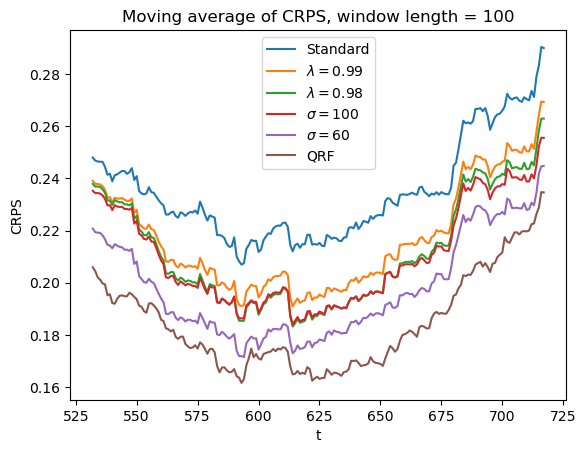

In [165]:
window = 100
plt.plot(np.arange(432+window,718),movingaverage(crps_s[432:718],window),label='Standard')
plt.plot(np.arange(432+window,718),movingaverage(crps_ne[432:718],window),label = '$\lambda=0.99$')
plt.plot(np.arange(432+window,718),movingaverage(crps_ne1[432:718],window),label = '$\lambda=0.98$')
plt.plot(np.arange(432+window,718),movingaverage(crps_ne2[432:718],window),label = '$\sigma=100$')
plt.plot(np.arange(432+window,718),movingaverage(crps_ne3[432:718],window),label = '$\sigma=60$')
plt.plot(np.arange(432+window,718),movingaverage(crps_QRF[432:718],window),label = 'QRF')
plt.legend()
plt.xlabel('t')
plt.ylabel('CRPS')
plt.title(f'Moving average of CRPS, window length = {window}')
plt.savefig('GOKI_crps_reset.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


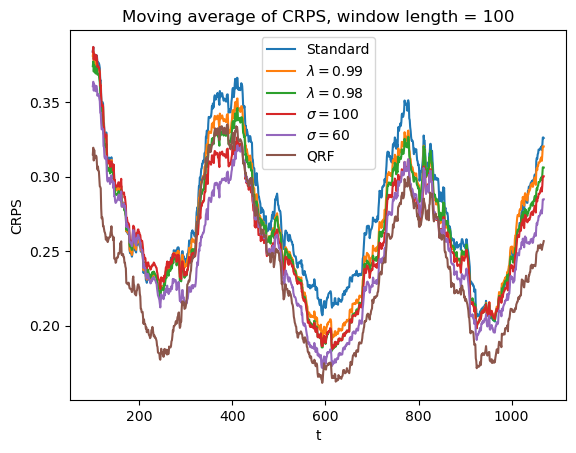

In [166]:
window = 100
plt.plot(np.arange(window,len(crps_s)),movingaverage(crps_s,window),label='Standard')
plt.plot(np.arange(window,len(crps_ne)),movingaverage(crps_ne,window),label = '$\lambda=0.99$')
plt.plot(np.arange(window,len(crps_ne1)),movingaverage(crps_ne1,window),label = '$\lambda=0.98$')
plt.plot(np.arange(window,len(crps_ne2)),movingaverage(crps_ne2,window),label = '$\sigma=100$')
plt.plot(np.arange(window,len(crps_ne3)),movingaverage(crps_ne3,window),label = '$\sigma=60$')
plt.plot(np.arange(window,len(crps_QRF)),movingaverage(crps_QRF,window),label = 'QRF')
plt.legend()
plt.xlabel('t')
plt.ylabel('CRPS')
plt.title(f'Moving average of CRPS, window length = {window}')
plt.savefig('GOKI_crps.eps', format='eps')

In [110]:
ind = np.arange(0,y.size)
rng.shuffle(ind)
x_shuff = x[ind]
y_shuff = y[ind]
print(ind)

[ 143  322 1246 ...  519  965 1313]


In [111]:
start_ind = 200
lam = 0.99
model,alpha,weights = calibrate(x_shuff[:start_ind,:],y_shuff[:start_ind],exp_decay,lam)
p_values_ne = np.empty((len(y)-start_ind))
p_values = np.empty((len(y)-start_ind))
pred_distr_ne = np.empty((len(y)-start_ind,200))
pred_distr= np.empty((len(y)-start_ind,200))
for i in np.arange(start_ind,len(y)):
    pred = model.predict(x_shuff[i,:].reshape(1,-1))
    p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y_shuff[i])
    p_values[i-start_ind] = p_value(pred,alpha,y_shuff[i])
    distr_ne,distr= predict_distr(pred,alpha,weights)
    pred_distr_ne[i-start_ind,:] = distr_ne
    pred_distr[i-start_ind,:] = distr
    if i % 10 == 9:
        model,alpha,weights = calibrate(x_shuff[:i,:],y_shuff[:i],exp_decay,lam)
    

/tmp/ipykernel_152548/3978559187.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y_shuff[i])
/tmp/ipykernel_152548/3978559187.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weights,y_shuff[i])
/tmp/ipykernel_152548/3978559187.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_values_ne[i-start_ind] = p_value_nonex(pred[0],alpha,weight

In [112]:
martin1 = plugin_martingale(p_values)

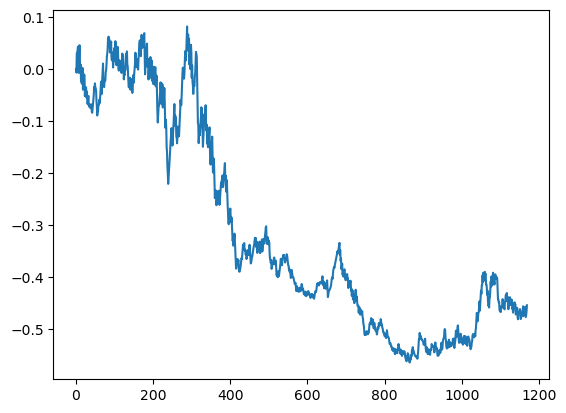

In [113]:
plt.plot([i for i in range(len(martin1))], [np.log10(m) for m in martin1],label='Standard')

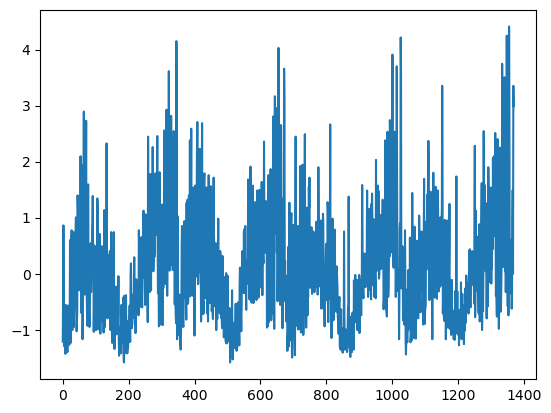

In [114]:
plt.plot(y)